## Prior Initialization Testing

In [72]:
import sys
import os

# Add the src folder (which is one level up and then into src/)
sys.path.append(os.path.abspath("../src"))

# Now import your function
from ansatz import create_improved_ansatz


In [73]:
ansatz, theta, phi, lambda_ = create_improved_ansatz(num_qubits=10, reps=5)

flat_params_list = theta + phi + lambda_

with open("../logs/pretrained_params.txt", "r") as f:
    params = f.read().strip().split()

with open("../logs/pretrain_fidelity_loss.txt", "r") as f:
    cost_history = f.read().strip().split()
    
params.pop(0)
params.pop(len(params) - 1)

cost_history.pop(0)
cost_history.pop(len(cost_history) - 1)

for i in range(len(params)):
    params[i] = float(params[i])
for i in range(len(cost_history)):
    cost_history[i] = float(cost_history[i])

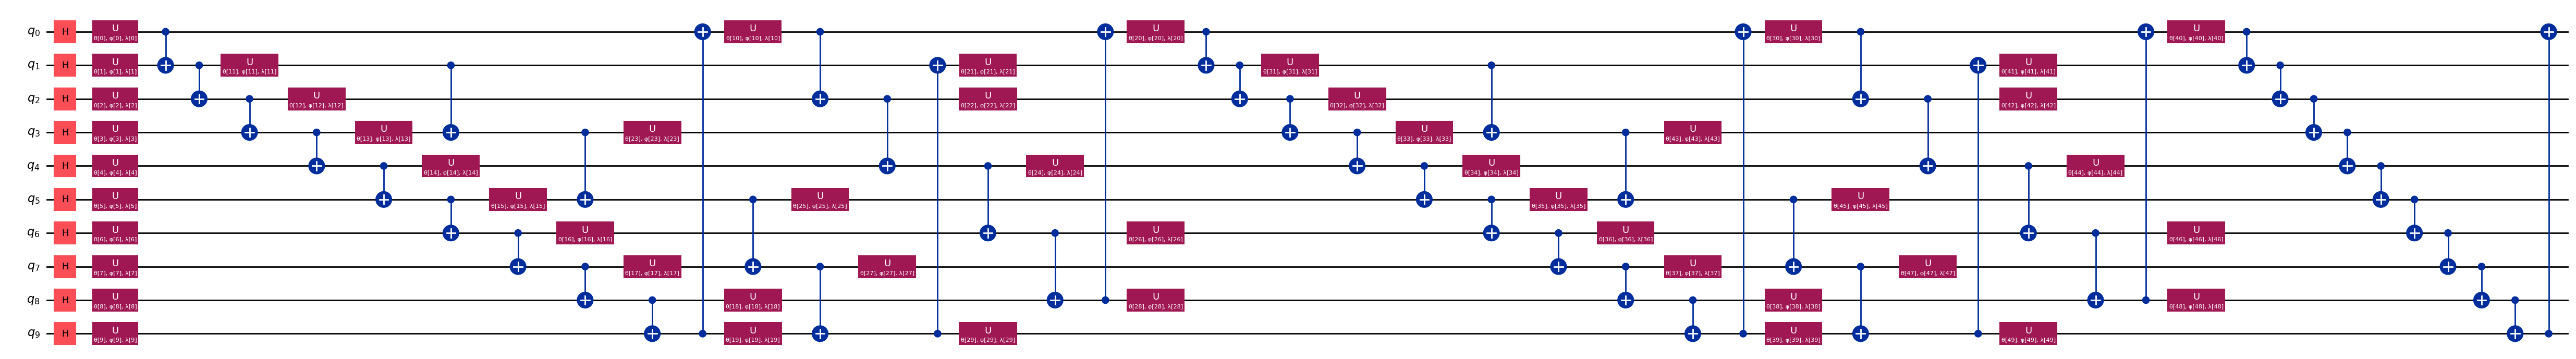

In [74]:
ansatz.draw('mpl', fold=-1)

In [75]:
from qiskit_ibm_runtime import Sampler
from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit

qc = QuantumCircuit(10, 10)
qc.compose(ansatz, inplace=True)
sample_qc = qc.copy()

backend = AerSimulator(method='matrix_product_state')
    
sampler = Sampler(mode=backend)
    
binding = {p: v for p, v in zip(flat_params_list, params)}
qc.assign_parameters(binding, inplace=True)
transpiled_qc = transpile(qc, backend=backend)


sv = Statevector.from_instruction(transpiled_qc)
probs = sv.probabilities()

sample_qc.measure(range(10), range(10))
sample_transpiled_qc = transpile(sample_qc, backend=backend)
job = sampler.run([(sample_transpiled_qc, binding)], shots=2048*4)
    
result = job.result()._pub_results[0].data.c
counts = result.get_counts()

In [76]:
bitstring_probs = {
    format(i, f'0{10}b'): float(p)
    for i, p in enumerate(probs)
    if p > 1e-10  # filter negligible terms
}
bitstring_probs

{'0000000000': 1.3147472752199392e-07,
 '0000000001': 1.4851294902210478e-07,
 '0000000010': 1.6453940236836983e-07,
 '0000000011': 1.0259799644585455e-07,
 '0000000100': 1.6334890031232158e-08,
 '0000000101': 8.542612933456619e-07,
 '0000000110': 1.0128422992625367e-07,
 '0000000111': 2.20518506183351e-06,
 '0000001000': 2.941709971293782e-07,
 '0000001001': 4.873270893881974e-08,
 '0000001010': 2.6696367148017554e-07,
 '0000001011': 4.804140485734221e-07,
 '0000001100': 6.00822271915595e-08,
 '0000001101': 6.645070951315612e-08,
 '0000001110': 1.3539044245625825e-07,
 '0000001111': 4.1389657942725453e-07,
 '0000010000': 3.9075481113208984e-06,
 '0000010001': 1.8258505981295582e-06,
 '0000010010': 4.176362188566552e-06,
 '0000010011': 1.98943257013199e-06,
 '0000010100': 6.460596538691346e-06,
 '0000010101': 3.6781957582759865e-06,
 '0000010110': 5.779798753080006e-06,
 '0000010111': 9.870939697212893e-06,
 '0000011000': 6.194999473802802e-06,
 '0000011001': 3.4507668144292976e-06,
 '

In [77]:
print(counts)
print(type(counts))

{'1110110111': 532, '1110110011': 179, '0001110111': 26, '1110111001': 107, '1110110000': 198, '0101010100': 792, '0101010111': 529, '1010010110': 85, '0101010011': 267, '0101010110': 628, '0101010010': 251, '0001110101': 21, '1110110100': 606, '0101011100': 16, '1110111011': 84, '0101010101': 704, '1010010101': 39, '0101011011': 77, '0001110001': 7, '1010011001': 13, '0101011001': 108, '1110110101': 645, '1110111111': 18, '1010010100': 48, '0101010000': 173, '0001111101': 8, '1010010111': 68, '1110110110': 415, '0101011000': 119, '1111001110': 1, '0000110010': 6, '1110111000': 113, '1010011010': 11, '1110110001': 138, '0101010001': 211, '1110110010': 256, '0000110100': 26, '0110101110': 1, '1110111101': 12, '1110111010': 59, '1000101000': 4, '1110111100': 27, '1111011000': 1, '0001110110': 30, '0101011010': 85, '0101011111': 36, '0000110110': 14, '1010010001': 25, '1010010011': 22, '0000110101': 23, '1000100010': 2, '0001110000': 9, '1000001011': 1, '0101011110': 16, '1000101011': 4, 

In [78]:
sorted_counts = dict(sorted(counts.items(), key=lambda item: int(item[0], 2)))

In [79]:
def bitstrings_to_ints(bitstrings: list) -> list:
    """
    Convert a list of bitstrings into a list of integers.
    
    Args:
        bitstrings: A list of strings, each a bitstring.
        
    Returns:
        A list of integers corresponding to the bitstrings.
    """
    return [int(b, 2) for b in bitstrings]

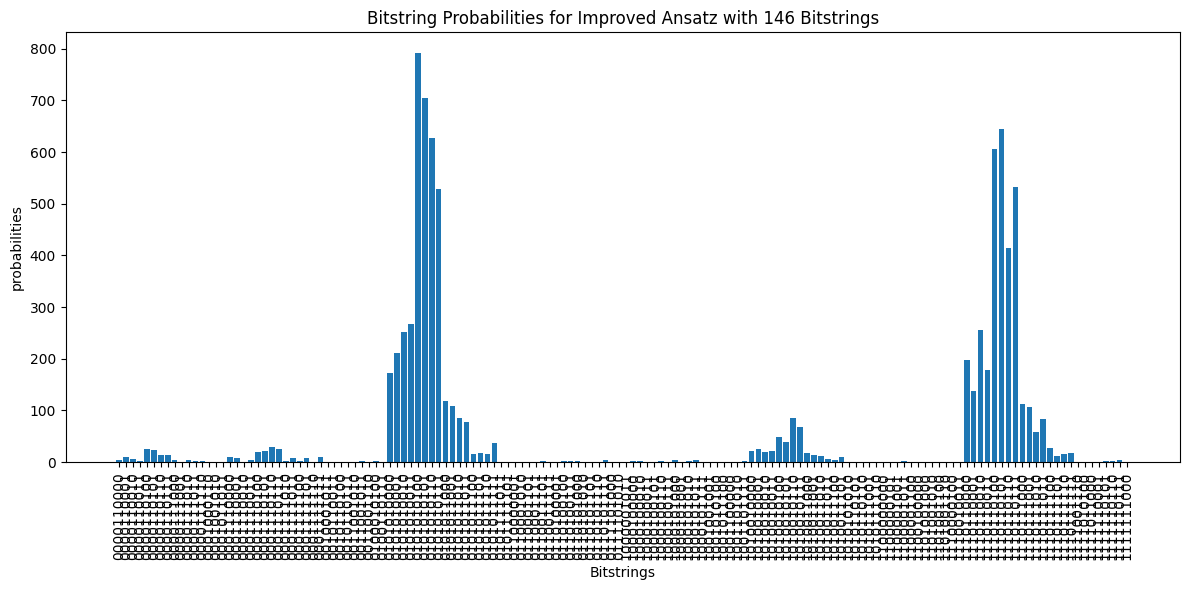

In [80]:
import matplotlib.pyplot as plt

top_len = 10

# Top 20 counts manually
top_counts = dict(sorted(bitstring_probs.items(), key=lambda item: item[1], reverse=True)[:top_len])

# bitstrings = [str(int(key, 2)) for key in counts.keys()]
bitstrings = list(sorted_counts.keys())
values = list(sorted_counts.values())

plt.figure(figsize=(12, 6))
plt.bar(bitstrings, values)
# plt.title(f'Top {top_len} Measurement Counts')
plt.title(f'Bitstring Probabilities for Improved Ansatz with {len(bitstrings)} Bitstrings')
plt.xlabel('Bitstrings')
plt.ylabel('probabilities')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [81]:
center_bitstring = "0111000000"

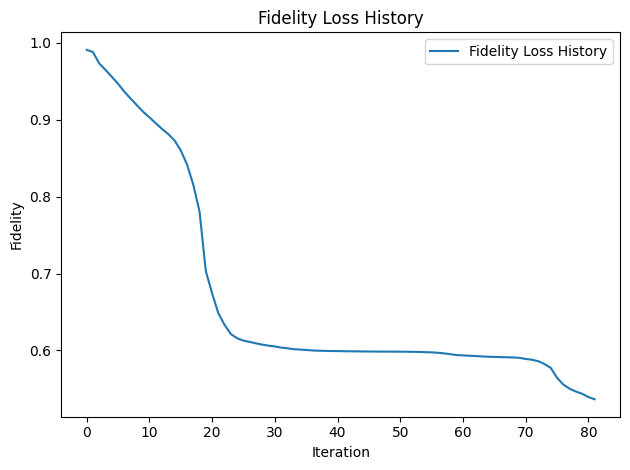

In [82]:
plt.plot(cost_history, label='Fidelity Loss History')
plt.title('Fidelity Loss History')
plt.xlabel('Iteration')
plt.ylabel('Fidelity')
plt.legend()
plt.tight_layout()
plt.show()

In [83]:
sum(values)

8192

In [84]:
most_frequent_bitstring = max(bitstring_probs, key=bitstring_probs.get)
print(f"Most frequent bitstring: {most_frequent_bitstring} with probability amplitude {bitstring_probs[most_frequent_bitstring]}")

Most frequent bitstring: 0101010100 with probability amplitude 0.10026194173228777


In [85]:
# top_counts["0111000000"]

## Cost Function Plotting 

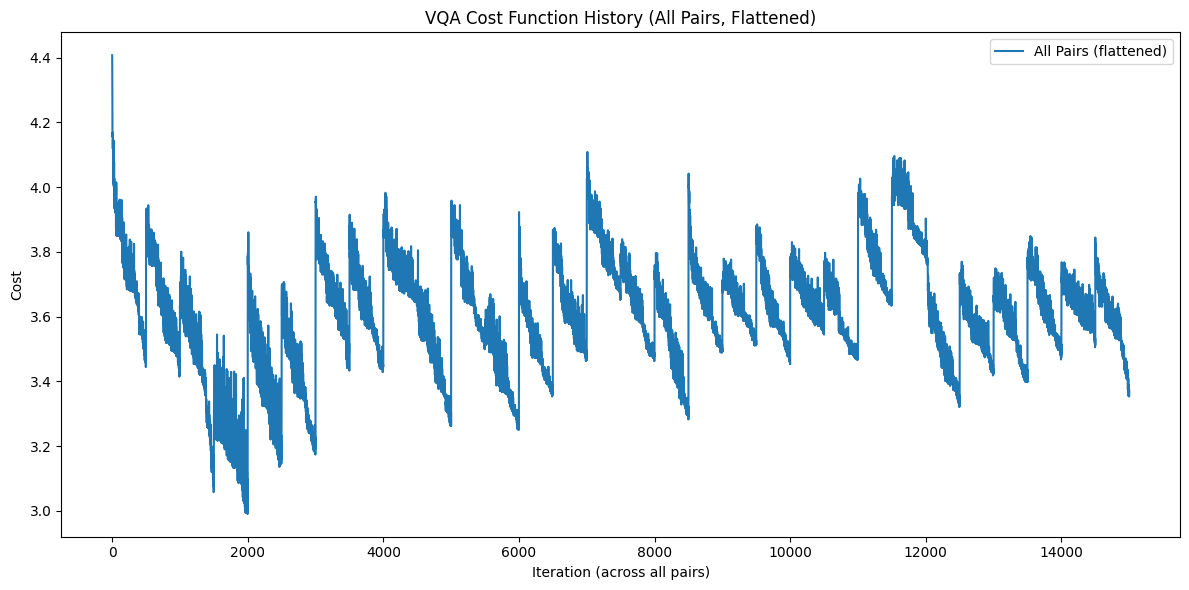

In [1]:
import json
import matplotlib.pyplot as plt

# Load the results
with open("../results2.json", "r") as f:
    results = json.load(f)

# If your JSON is a list of results, get the first element
res_len = len(results)
cost_history_per_pair = results[res_len - 3]["cost_history_per_pair"]
all_costs = [cost for pair in cost_history_per_pair for cost in pair]


# Plot as a single continuous line
plt.figure(figsize=(12, 6))
plt.plot(all_costs, label='All Pairs (flattened)')
plt.xlabel("Iteration (across all pairs)")
plt.ylabel("Cost")
plt.title("VQA Cost Function History (All Pairs, Flattened)")
plt.legend()
plt.tight_layout()
plt.show()

True key is 1011010101
Most probable key is : 1011010101


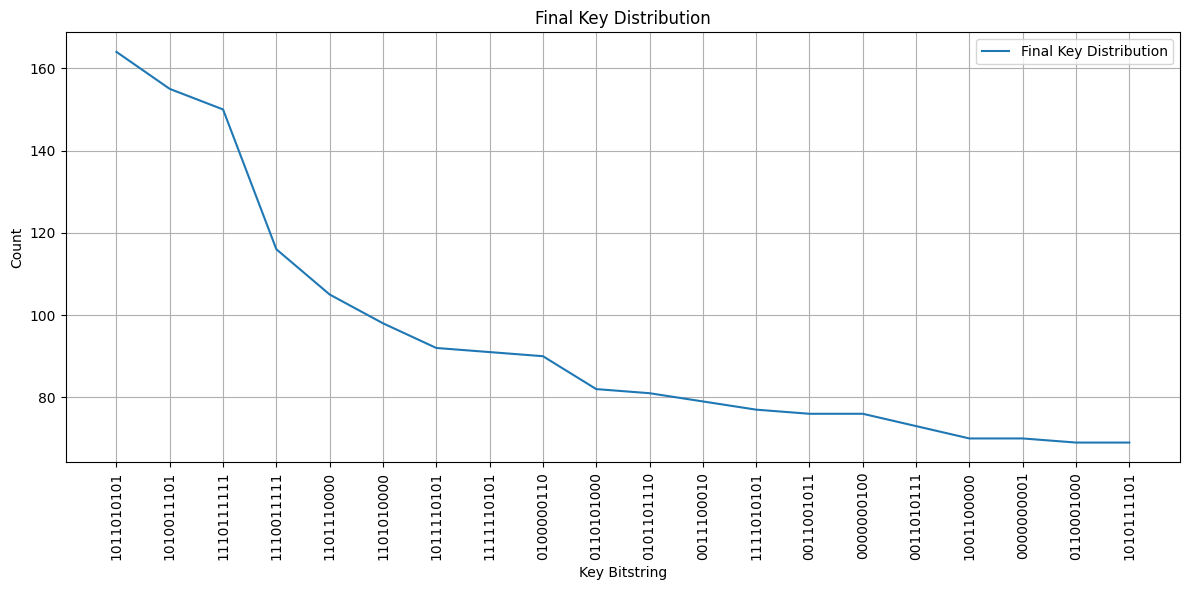

In [2]:
final_counts_array = results[res_len - 3]["top_20_bitstrings"]
final_counts = {kv[0] : kv[1] for kv in final_counts_array}
print(f"True key is {results[res_len - 3]["true_key"]}")
print(f"Most probable key is : {final_counts_array[0][0]}")
plt.figure(figsize=(12, 6))
plt.plot(final_counts.keys(), final_counts.values(), label='Final Key Distribution')
plt.xlabel("Key Bitstring")
plt.ylabel("Count")
plt.title("Final Key Distribution")
plt.legend()
plt.grid()
plt.xticks(rotation=90)
plt.margins()
plt.tight_layout()
plt.show()

# Extra tests

## Hamming distance

In [29]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt


def hamming_gaussian_prior(n_bits: int, center_key: np.ndarray, std_dev: float) -> np.ndarray:
    """
    Construct a normalized Gaussian prior over all 2^n_bits possible keys,
    where distance is measured by Hamming distance to center_key.

    Args:
        n_bits: Number of bits in the key (e.g., 10).
        center_key: A length-n_bits numpy array of 0s and 1s indicating the center of the prior.
        std_dev: Standard deviation for the Gaussian on Hamming distance.

    Returns:
        A length-(2^n_bits) numpy array of probabilities summing to 1.
    """
    # Enumerate all 2^n_bits keys as bit arrays
    all_keys = np.array([list(map(int, format(i, f"0{n_bits}b"))) for i in range(2**n_bits)])
    # Compute Hamming distance to center_key for each key
    hamming_dist = np.sum(all_keys != center_key, axis=1)
    # Evaluate Gaussian PDF at those distances (mean=0)
    probs = norm.pdf(hamming_dist, 0, std_dev)
    # Normalize into a probability distribution
    return probs / np.sum(probs)


def hamming_distance(str1: str, str2: str) -> int:
    """
    Compute the Hamming distance between two equal-length bitstrings.

    Args:
        str1: First bitstring (e.g., "1010010101").
        str2: Second bitstring of the same length.

    Returns:
        The number of positions at which the corresponding bits differ.
    """
    if len(str1) != len(str2):
        raise ValueError("Strings must be of equal length.")
    return sum(c1 != c2 for c1, c2 in zip(str1, str2))

## Cosine Distance

In [30]:
import numpy as np

def cosine_distance(x, y):
    """Cosine distance = 1 - cosine similarity"""
    dot = np.dot(x, y)
    norm_product = np.linalg.norm(x) * np.linalg.norm(y)
    if norm_product == 0:
        return 1.0  # define max distance if either is zero vector
    return 1 - (dot / norm_product)

def cosine_gaussian_prior(n_bits: int, center_key: np.ndarray, std_dev: float) -> np.ndarray:
    """
    Construct a Gaussian prior over 2^n_bits binary keys based on cosine distance.
    
    Args:
        n_bits: Number of bits per key.
        center_key: Binary array of length n_bits representing the center.
        std_dev: Standard deviation for the Gaussian kernel over cosine distance.
    
    Returns:
        Normalized prior (length 2^n_bits) as numpy array.
    """
    num_keys = 2**n_bits
    all_keys = np.array([list(map(int, format(i, f"0{n_bits}b"))) for i in range(num_keys)])
    
    # Compute cosine distances
    distances = np.array([cosine_distance(key, center_key) for key in all_keys])
    
    # Apply Gaussian kernel: exp(-0.5 * (distance / std_dev)^2)
    unnormalized = np.exp(-0.5 * (distances / std_dev)**2)
    prior = unnormalized / np.sum(unnormalized)
    
    return prior


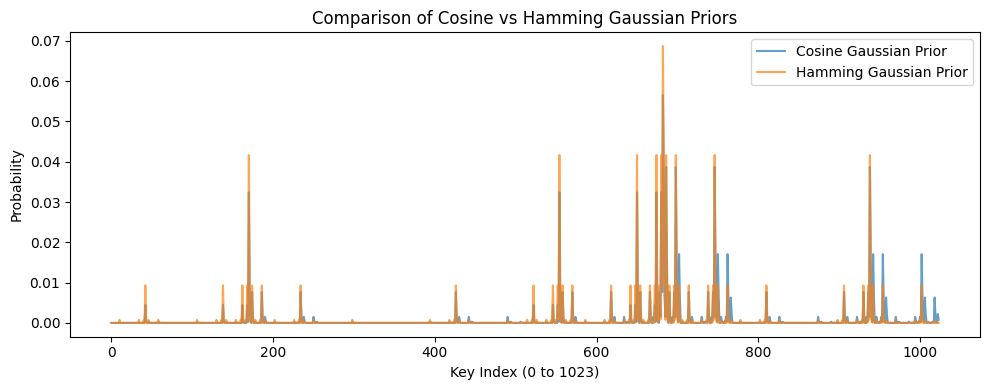

In [31]:
import matplotlib.pyplot as plt
import numpy as np

center = np.array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0])


prior_cosine = cosine_gaussian_prior(10, center, std_dev=0.1)
prior_hamming = hamming_gaussian_prior(10, center, std_dev=1.0)

x = np.arange(2**10)

plt.figure(figsize=(10, 4))
plt.plot(x, prior_cosine, label="Cosine Gaussian Prior", alpha=0.7)
plt.plot(x, prior_hamming, label="Hamming Gaussian Prior", alpha=0.7)
plt.xlabel("Key Index (0 to 1023)")
plt.ylabel("Probability")
plt.title("Comparison of Cosine vs Hamming Gaussian Priors")
plt.legend()
plt.tight_layout()
plt.show()



## Final param simulation 

In [39]:
import json

with open('../track_results.json', 'r') as f:
    data = json.load(f)
print(data)

{'best_params_per_pair': [[3.51835037, 6.28312034, 4.64212622, 3.14053056, 0.000667678447, 1.77162846, -2.91352193e-05, 5.68493542, 3.86670806, 3.14176832, -0.00125386589, 7.28318544, 6.19165947, 1.56998357, 2.1348186, -0.000381542745, 1.54152507, 3.12705262, 3.14163092, 1.57082512, 4.71240827, -6.88637922e-05, 1.72402311, 3.13960787, 3.14277705, 4.71235372, 1.54943087, 3.14158301, 4.71235845, 0.000321872079, 4.71240164, 5.87200821e-05, -0.00208085761, 6.28314312, 6.2153645, 4.70903878, 0.000257871046, 0.164065948, 4.71290572, 3.14167318, -0.00120763956, 3.14141036, -0.00079969796, 6.2832087, 1.57081205, 4.7123563, 1.57085998, 3.14180592, 1.57086386, 1.57073438, 6.28316952, 4.3411433, 6.28348357, 5.55691358, 4.06398275, 4.71179673, 0.867898579, 0.0412135578, 0.0180968861, 2.31022357, 2.77370633, 1.22442309, 4.88731376, 2.57274473, 1.57079303, 3.94712684, 1.42580658, 4.67296772, 1.14252015, 6.28320723, 4.70678652, 2.53612616, 0.581468971, 5.27101349, 4.47401393, 4.69785028, 4.71242957, 

In [40]:
params = data["best_params_per_pair"][4]

In [41]:
ansatz, theta, phi, lambda_ = create_improved_ansatz(num_qubits=10, reps=5)

flat_params_list = theta + phi + lambda_

In [42]:
from qiskit_ibm_runtime import Sampler
from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit

qc = QuantumCircuit(10, 10)
qc.compose(ansatz, inplace=True)
sample_qc = qc.copy()

backend = AerSimulator(method='matrix_product_state')
    
sampler = Sampler(mode=backend)
    
binding = {p: v for p, v in zip(flat_params_list, params)}
qc.assign_parameters(binding, inplace=True)
transpiled_qc = transpile(qc, backend=backend)


sv = Statevector.from_instruction(transpiled_qc)
probs = sv.probabilities()

sample_qc.measure(range(10), range(10))
sample_transpiled_qc = transpile(sample_qc, backend=backend)
job = sampler.run([(sample_transpiled_qc, binding)], shots=2048*4)
    
result = job.result()._pub_results[0].data.c
counts = result.get_counts()

In [43]:
bitstring_probs = {
    format(i, f'0{10}b'): float(p)
    for i, p in enumerate(probs)
    if p > 1e-10  # filter negligible terms
}
bitstring_probs

{'0000000000': 0.001037946373469299,
 '0000000001': 0.0011658924103333872,
 '0000000010': 0.001091093133255034,
 '0000000011': 0.0007862639669439693,
 '0000000100': 0.0006117706506063717,
 '0000000101': 0.001414229839180173,
 '0000000110': 0.0013133113759808562,
 '0000000111': 0.000737174198783777,
 '0000001000': 0.0005925821874178151,
 '0000001001': 0.00023528584705787613,
 '0000001010': 0.00020942395783095214,
 '0000001011': 0.0005322964126198654,
 '0000001100': 0.00021365016876521785,
 '0000001101': 0.00014480354996469788,
 '0000001110': 0.00012739748648433566,
 '0000001111': 0.00013092454145041056,
 '0000010000': 3.0450539846181956e-05,
 '0000010001': 2.864350101073181e-05,
 '0000010010': 2.5407397649313074e-05,
 '0000010011': 2.7651986369472035e-05,
 '0000010100': 0.00011852962397717496,
 '0000010101': 0.00016865540792798398,
 '0000010110': 0.00016440920023215358,
 '0000010111': 0.00012218259138944065,
 '0000011000': 0.0023305832991918677,
 '0000011001': 0.0011696091983924048,
 '0

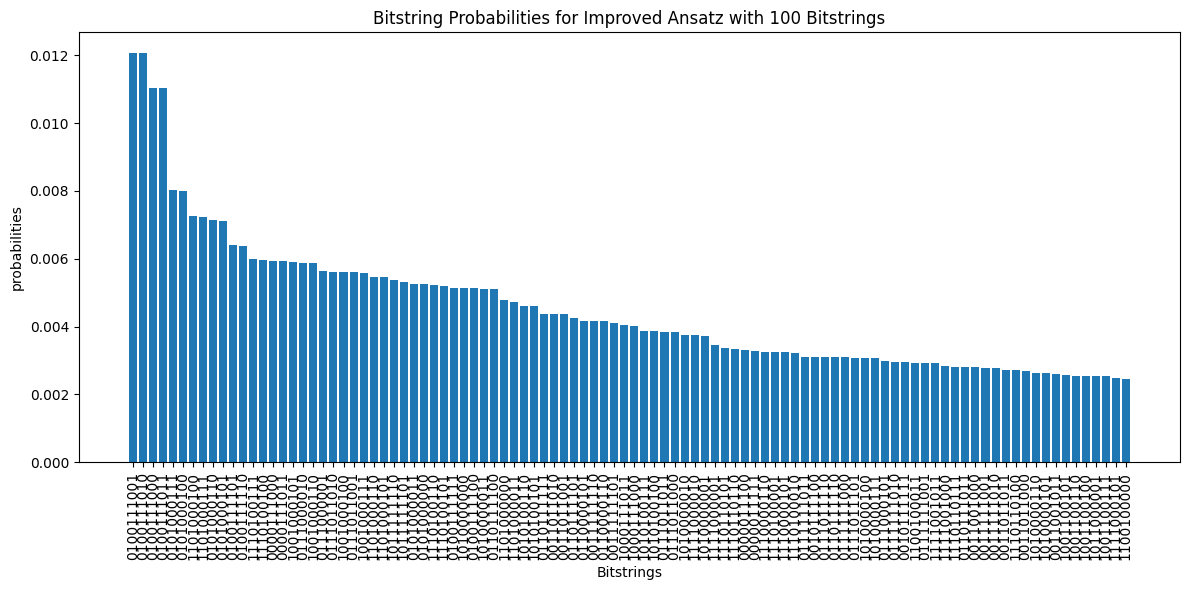

In [44]:
import matplotlib.pyplot as plt

top_len = 100

# Top 20 counts manually
top_counts = dict(sorted(bitstring_probs.items(), key=lambda item: item[1], reverse=True)[:top_len])

# bitstrings = [str(int(key, 2)) for key in top_counts.keys()]
bitstrings = list(top_counts.keys())
values = list(top_counts.values())

plt.figure(figsize=(12, 6))
plt.bar(bitstrings, values)
# plt.title(f'Top {top_len} Measurement Counts')
plt.title(f'Bitstring Probabilities for Improved Ansatz with {len(bitstrings)} Bitstrings')
plt.xlabel('Bitstrings')
plt.ylabel('probabilities')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [45]:
top_counts["0111000010"]

0.005869727229079993

## Hamiltonian


In [96]:
plaintext = "00011101"
key = "0111010010"

from sdes import sdes_encrypt
ciphertext = sdes_encrypt(plaintext, key)

In [137]:
ciphertext = "00000000"

In [138]:
from hamiltonian import build_hamiltonian
ham = build_hamiltonian(ciphertext)

In [139]:
ciphertext

'00000000'

In [140]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, SparsePauliOp

qc = QuantumCircuit(10, 10)
qc.x([1, 4, 6, 7, 8])

sv = Statevector.from_instruction(qc)
probs = sv.probabilities_dict()

In [141]:
from collections import defaultdict

cipher_probs = defaultdict(float)

for k, v in probs.items():
    key = sdes_encrypt(plaintext, k)
    cipher_probs[key] += v

In [142]:
cipher_probs = {"00000000": 0.5, "11111111": 0.5}

In [143]:
def basis_state_expectation(cipher_text : str, hamiltonian : SparsePauliOp):
    sv = Statevector.from_label(cipher_text)
    exp = sv.expectation_value(hamiltonian)
    return exp    

In [144]:
expectation_value = (np.real(list([(basis_state_expectation(k, ham) * v) for k, v in cipher_probs.items()])))
expectation_value.sum()

np.float64(-24.0)

In [145]:
print(len(probs))
print(len(cipher_probs))

1
2


In [ ]:

# // Prior key is 2 bits away from actual key and hamming gaussian is used for pretraining with L-BFGS-B optimizer, expectation value calculation is changed and  vqa optimizer runs L-BFGS-B at 400 iters

## Ansatz

In [3]:
from ansatz import create_improved_ansatz, create_2local_ansatz, create_efficient_su2_ansatz

ansatz1, theta, phi, lambda_ = create_improved_ansatz(num_qubits=21, reps=5)
ansatz1.decompose().depth()


91

In [4]:
ansatz2, theta, phi, lambda_ = create_improved_ansatz(num_qubits=21, reps=1)
ansatz2.decompose().depth()

23